In [41]:
import sys
import pickle
from pathlib import Path
gpu_implementation_path = '/home/mt/repos/research.mtne/gpu_implementation'
if gpu_implementation_path not in sys.path:
    sys.path.append(gpu_implementation_path)
import re
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from esmt import TrainingState

main_log_dir = Path(gpu_implementation_path) / "logs"

In [42]:
log_session = "MT-zaxxon-riverraid-5000-2k"

In [43]:
# log_session = "salvatore-0to70"
logdir = main_log_dir / log_session
iterlogfiles = {}

iterations = []
for i in logdir.iterdir():
    f = i.name
    if not f.endswith('-game1_elite.pkl'):
        continue
    itr = re.sub('^0*', '', f.split('-')[0])
    if itr == '':
        itr = 0
    else:
        itr = int(itr)
    iterations.append(itr)
iterations.sort()
last_iteration = iterations[-1]

def get_iter_log(iteration, pickle_file):
    filename = logdir / "{:04d}-{}.pkl".format(iteration, pickle_file)
    with open(str(filename), 'rb') as f:
        return pickle.load(f)

def get_iter_logs(iteration):
    df = {}
    loadfiles = ['state', 'offsprings',
                 'game0_elite', 'game0_rewards', 'game0_episode_lengths',
                 'game1_elite', 'game1_rewards', 'game1_episode_lengths'
                ]
    for loadfile in loadfiles:
        df[loadfile] = get_iter_log(iteration, loadfile)
    return df

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.rad2deg(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

def compute_ranks(x):
    """
    Returns ranks in [0, len(x))
    Note: This is different from scipy.stats.rankdata, which returns ranks in [1, len(x)].
    """
    assert x.ndim == 1
    ranks = np.empty(len(x), dtype=int)
    ranks[x.argsort()] = np.arange(len(x))
    return ranks

def compute_centered_ranks(x):
    y = compute_ranks(x.ravel()).reshape(x.shape).astype(np.float32)
    y /= (x.size - 1)
    y -= .5
    return y

rewards_df = pd.DataFrame(columns=['game0_rewards', 'game1_rewards', 'game0_elite', 'game1_elite', 'iteration'])
for i in iterations:
#     print("Loading iteration {}".format(i))
    df = {
        'game0_rewards': [np.mean(get_iter_log(i, 'game0_rewards'))],
        'game1_rewards': [np.mean(get_iter_log(i, 'game1_rewards'))],
        'game0_elite': [np.mean(get_iter_log(i, 'game0_elite'))],
        'game1_elite': [np.mean(get_iter_log(i, 'game1_elite'))]
    }
    df['iteration'] = [i]
    rdf = pd.DataFrame.from_dict(df)
    rewards_df = pd.concat([rewards_df, rdf], sort=True)
print("Last iteration: {}".format(max(iterations)))

Last iteration: 153


In [44]:
def get_config_body(logdir):
    with open(str(logdir / "log.txt"), "r") as f:
        data = f.read()
    config_data = data.find(" Logging to: ")
    return data[0:config_data]
print(get_config_body(logdir))

09/01/2019 09:52:47 PM {
    "episode_cutoff_mode": 5000,
    "games": [
        "zaxxon",
        "riverraid"
    ],
    "iterations": 2001,
    "l2coeff": 0.005,
    "learn_option": "concat_rewards",
    "learn_options": [
        "concat_rewards",
        "alternate_games",
        "equal_prob_random_choice"
    ],
    "model": "ModelVirtualBN",
    "mutation_power": 0.02,
    "num_test_episodes": 400,
    "num_validation_episodes": 30,
    "optimizer": {
        "args": {
            "stepsize": 0.01
        },
        "type": "adam"
    },
    "population_size": 10000,
    "population_size_comment": "Must be divisible by 4",
    "return_proc_mode": "centered_rank",
    "timesteps": Infinity
}
09/01/2019 09:52:47 PM


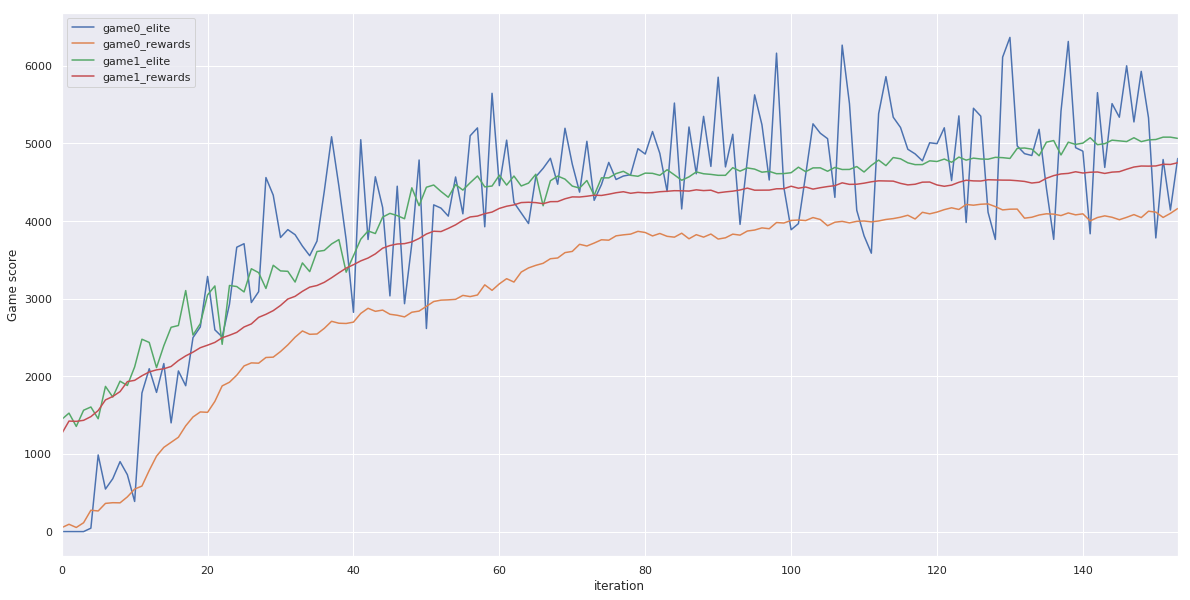

In [45]:
sns.set(rc={'figure.figsize':(20, 10)})
rewards_df.set_index('iteration')
myplot = rewards_df.set_index('iteration').plot()
myplot.set(ylabel='Game score')
fig = myplot.get_figure()
fig.savefig("myfig.eps", format='eps')

Last iteration: 137


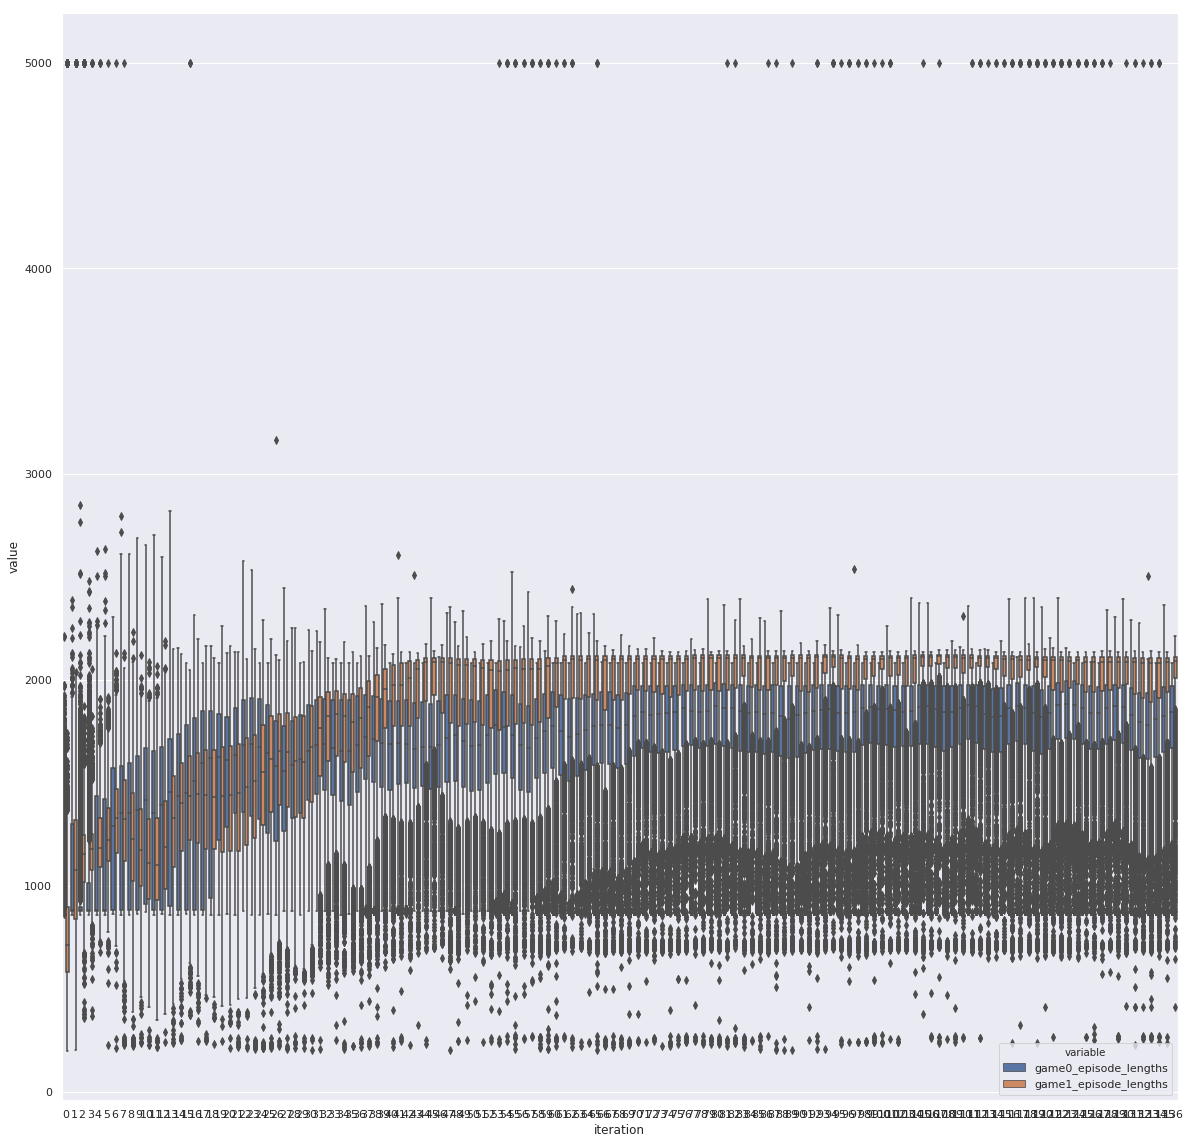

In [36]:
eplens_df = pd.DataFrame(columns=[
    'game0_episode_lengths',
    'game1_episode_lengths', 
    'iteration'
])

for i in range(last_iteration):
#     print("Loading iteration {}".format(i))
    df = {
        'game0_episode_lengths': np.array([l for l in get_iter_log(i, 'game0_episode_lengths')]).flatten(),
        'game1_episode_lengths': np.array([l for l in get_iter_log(i, 'game1_episode_lengths')]).flatten(),
    }
    df['iteration'] = [i] * df['game0_episode_lengths'].shape[0]
    edf = pd.DataFrame.from_dict(df)
    eplens_df = pd.concat([eplens_df, edf], sort=True)
print("Last iteration: {}".format(max(iterations)))
m = pd.melt(eplens_df, id_vars=['iteration'], value_vars=['game0_episode_lengths', 'game1_episode_lengths'])
m['value'] = m['value'].astype('float32')
m['variable'] = m['variable'].astype('category')
m = m.query('iteration >= 0')
sns.set(rc={'figure.figsize':(20, 20)})
sns.boxplot(x='iteration', y='value', hue='variable', data=m)

In [37]:
reward_eplen = pd.DataFrame(columns=['eplen', 'reward', 'iteration'])
for i in range(last_iteration):
    df = {
        'eplen': np.array(get_iter_log(i, 'game0_episode_lengths')).flatten(),
        'reward': np.array(get_iter_log(i, 'game0_rewards')).flatten()
    }
    edf0 = pd.DataFrame.from_dict(df)
    edf0['game'] = [0] * edf0['eplen'].shape[0]
    edf0['iteration'] = [i] * edf0['eplen'].shape[0]

    df = {
        'eplen': np.array(get_iter_log(i, 'game1_episode_lengths')).flatten(),
        'reward': np.array(get_iter_log(i, 'game1_rewards')).flatten()
    }
    edf1 = pd.DataFrame.from_dict(df)
    edf1['game'] = [1] * edf1['eplen'].shape[0]
    edf1['iteration'] = [float(i)] * edf1['eplen'].shape[0]

    reward_eplen = pd.concat([reward_eplen, edf0, edf1], sort=True)

[Text(0.5, 1.0, 'Game 0 episode length vs reward')]

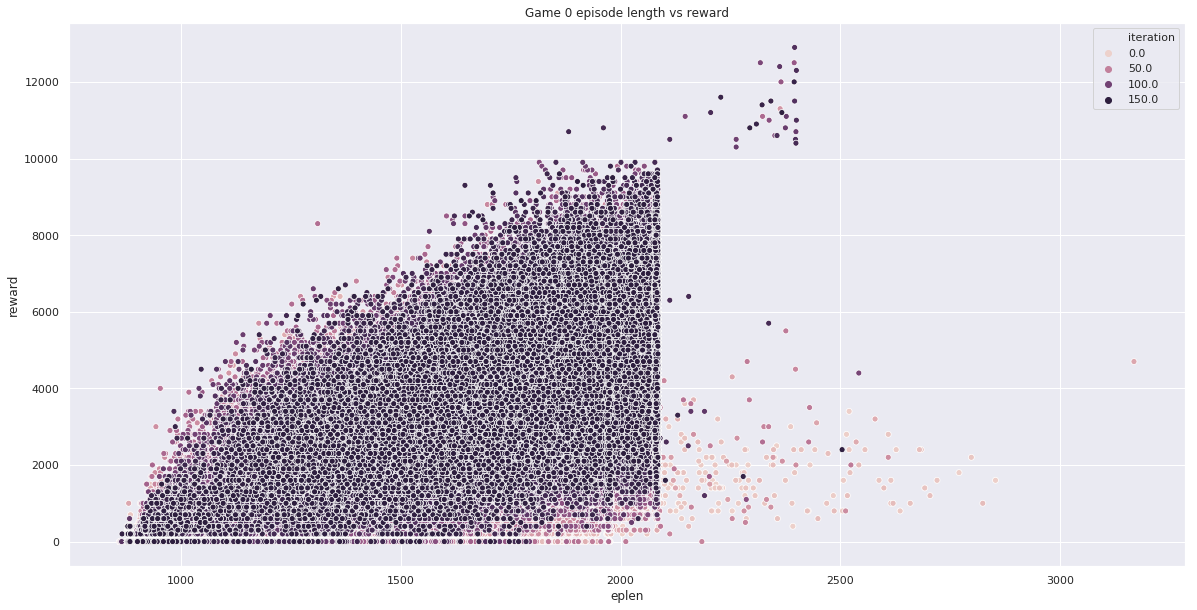

In [38]:
sns.set(rc={'figure.figsize':(20, 10)})
sns.scatterplot(x='eplen', y='reward', hue='iteration', data=reward_eplen.query('game == 0')).set(title='Game 0 episode length vs reward')

[Text(0.5, 1.0, 'Game 1 episode length vs reward')]

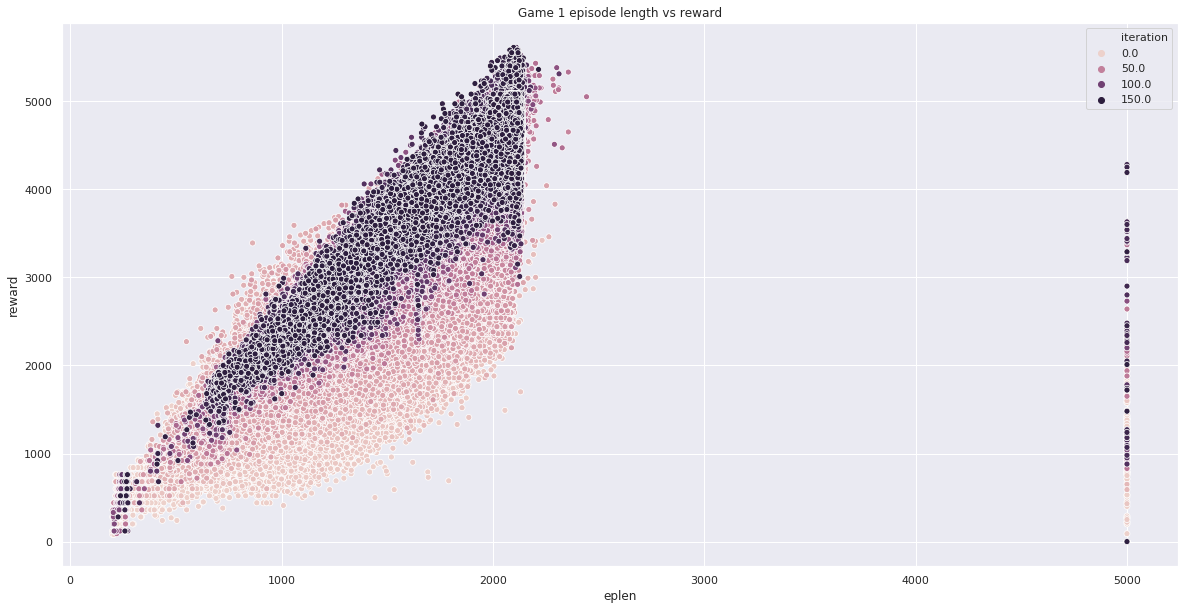

In [39]:
sns.set(rc={'figure.figsize':(20, 10)})
sns.scatterplot(x='eplen', y='reward', hue='iteration', data=reward_eplen.query('game == 1')).set(title='Game 1 episode length vs reward')

In [40]:
# thetas = pd.DataFrame(columns=['iteration', 'theta'])
# for iteration in iterations:
#     print("Loading iteration {}".format(iteration))
#     thetas = pd.concat(
#         [thetas,
#          pd.DataFrame.from_dict({
#              'iteration': [iteration] * 1008450,
#              'theta': np.array(get_iter_log(iteration, 'state').theta)
#          })
#         ]
#     )

In [63]:
# %time
# theta_deltas = []
# for ti in iterations[1:]:
#     print("Calculating {}".format(ti))
#     tc = thetas[thetas['iteration'] == ti]['theta'].values
#     tp = thetas[thetas['iteration'] == ti-1]['theta'].values
#     td = np.linalg.norm(tc - tp)
#     theta_deltas.append(td)

In [64]:
# pd.DataFrame(theta_deltas).plot()

In [65]:
# %time
# theta_deltas_from0 = []
# t0 = thetas[thetas['iteration'] == 0]['theta'].values
# for ti in iterations[1:-1]:
#     print("Calculating {}".format(ti))
#     tc = thetas[thetas['iteration'] == ti]['theta'].values
#     td = np.linalg.norm(tc - t0)
#     theta_deltas_from0.append(td)

In [66]:
# pd.DataFrame(theta_deltas).plot()

In [67]:
# sns.set(rc={'figure.figsize':(20, 10)})
# pd.DataFrame(theta_deltas_from0).plot()

In [68]:
# ms = pd.DataFrame(columns=['iteration', 'game0_mean', 'game0_std', 'game1_mean', 'game1_std'])
# for iteration in iterations:
#     game0_rewards = np.array(get_iter_log(iteration, 'game0_rewards'))
#     game1_rewards = np.array(get_iter_log(iteration, 'game1_rewards'))
    
#     game0_centered_ranks = compute_centered_ranks(game0_rewards)
#     game1_centered_ranks = compute_centered_ranks(game1_rewards)
    
#     game0_centered = np.abs(game0_centered_ranks[:, 0] - game0_centered_ranks[:, 1])
#     game1_centered = np.abs(game1_centered_ranks[:, 0] - game1_centered_ranks[:, 1])
    
#     game0_centered_top = np.sort(game0_centered)[-10:]
#     game1_centered_top = np.sort(game1_centered)[-10:]
    
    
#     m0, s0 = game0_centered_top.mean(), game0_centered_top.std()
#     m1, s1 = game1_centered_top.mean(), game1_centered_top.std()
#     d = {'iteration': iteration, 'game0_mean': [m0], 'game0_std': [s0], 'game1_mean': [m1], 'game1_std': [s1]}
#     ms = pd.concat([ms, pd.DataFrame.from_dict(d)], sort=True)
# sns.set(rc={'figure.figsize':(20, 10)})
# ms.set_index('iteration').plot()